# 1.bis. CBoW demo (Full text)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (29/08/2023)

Ths notebook demonstrates how we may design and train a CBoW architecture, on a very simple corpus of text. The dataset is not large enough to produce a good language model, but we do not expect students to be able to run it on a massive dataset, for computational costs reasons.

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.2)
- Numpy (tested on v1.25.2)
- Torch (tested on v2.0.1+cu118)
- We also strongly recommend setting up CUDA on your machine!

This notebook is similar to Notebook 1., but with a longer text.

### Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

### Step 1. Produce some data based on a given text for training our CBoW model    

In [2]:
def text_to_train(text, context_window):
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        context = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        target = text[i]
        data.append((context, target))
        
    return data

In [3]:
def create_text():
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [5]:
def generate_data(text, context_window):
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'citizens', 'usual', 'former', 'exile', 'off', 'engulfed', 'life', 'ring', 'marked', 'in', 'slopes', 'out', 'white', 'rude', 'vast', 'never', 'would', 'moment', 'cities', 'slaveowners', 'satisfied', 'refuse', 'declaration', 'created', 'sadly', 'still', 'rockies', 'not', 'hands', 'opportunity', 'thank', 'later', 'happy', 'content', 'hampshire', 'history', 'funds', 'spot', 'faith', 'their', 'country', 'symphony', 'bad', 'obligation', 'independence', 'has', 'tribulations', 'momentous', 'well', 'languishing', 'only', 'lives', 'speed', 'catholics', 'it', 'on', 'sixtythree', 'instead', 'travel', 'your', 'am', 'somehow', 'prosperity', 'climb', 'louisiana', 'nor', 'continue', 'symbolic', 'nullification', 'redemptive', 'discords', 'magnificent', 'no', 'brutality', 'whose', 'having', 'end', 'decree', 'underestimate', 'little', 'south', 'fatal', 'say', 'score', 'alleghenies', 'honoring', 'heightening', 'crooked', 'island', 'night', 'together', 'from', 'friends', 'carolina', 'hallowed', 'be', 'ev

In [8]:
print(word2index)

{'citizens': 0, 'usual': 1, 'former': 2, 'exile': 3, 'off': 4, 'engulfed': 5, 'life': 6, 'ring': 7, 'marked': 8, 'in': 9, 'slopes': 10, 'out': 11, 'white': 12, 'rude': 13, 'vast': 14, 'never': 15, 'would': 16, 'moment': 17, 'cities': 18, 'slaveowners': 19, 'satisfied': 20, 'refuse': 21, 'declaration': 22, 'created': 23, 'sadly': 24, 'still': 25, 'rockies': 26, 'not': 27, 'hands': 28, 'opportunity': 29, 'thank': 30, 'later': 31, 'happy': 32, 'content': 33, 'hampshire': 34, 'history': 35, 'funds': 36, 'spot': 37, 'faith': 38, 'their': 39, 'country': 40, 'symphony': 41, 'bad': 42, 'obligation': 43, 'independence': 44, 'has': 45, 'tribulations': 46, 'momentous': 47, 'well': 48, 'languishing': 49, 'only': 50, 'lives': 51, 'speed': 52, 'catholics': 53, 'it': 54, 'on': 55, 'sixtythree': 56, 'instead': 57, 'travel': 58, 'your': 59, 'am': 60, 'somehow': 61, 'prosperity': 62, 'climb': 63, 'louisiana': 64, 'nor': 65, 'continue': 66, 'symbolic': 67, 'nullification': 68, 'redemptive': 69, 'discords

In [9]:
print(index2word)

{0: 'citizens', 1: 'usual', 2: 'former', 3: 'exile', 4: 'off', 5: 'engulfed', 6: 'life', 7: 'ring', 8: 'marked', 9: 'in', 10: 'slopes', 11: 'out', 12: 'white', 13: 'rude', 14: 'vast', 15: 'never', 16: 'would', 17: 'moment', 18: 'cities', 19: 'slaveowners', 20: 'satisfied', 21: 'refuse', 22: 'declaration', 23: 'created', 24: 'sadly', 25: 'still', 26: 'rockies', 27: 'not', 28: 'hands', 29: 'opportunity', 30: 'thank', 31: 'later', 32: 'happy', 33: 'content', 34: 'hampshire', 35: 'history', 36: 'funds', 37: 'spot', 38: 'faith', 39: 'their', 40: 'country', 41: 'symphony', 42: 'bad', 43: 'obligation', 44: 'independence', 45: 'has', 46: 'tribulations', 47: 'momentous', 48: 'well', 49: 'languishing', 50: 'only', 51: 'lives', 52: 'speed', 53: 'catholics', 54: 'it', 55: 'on', 56: 'sixtythree', 57: 'instead', 58: 'travel', 59: 'your', 60: 'am', 61: 'somehow', 62: 'prosperity', 63: 'climb', 64: 'louisiana', 65: 'nor', 66: 'continue', 67: 'symbolic', 68: 'nullification', 69: 'redemptive', 70: 'disc

In [10]:
print(data)

[(['i', 'am', 'to', 'join'], 'happy'), (['am', 'happy', 'join', 'with'], 'to'), (['happy', 'to', 'with', 'you'], 'join'), (['to', 'join', 'you', 'today'], 'with'), (['join', 'with', 'today', 'in'], 'you'), (['with', 'you', 'in', 'what'], 'today'), (['you', 'today', 'what', 'will'], 'in'), (['today', 'in', 'will', 'go'], 'what'), (['in', 'what', 'go', 'down'], 'will'), (['what', 'will', 'down', 'in'], 'go'), (['will', 'go', 'in', 'history'], 'down'), (['go', 'down', 'history', 'as'], 'in'), (['down', 'in', 'as', 'the'], 'history'), (['in', 'history', 'the', 'greatest'], 'as'), (['history', 'as', 'greatest', 'demonstration'], 'the'), (['as', 'the', 'demonstration', 'for'], 'greatest'), (['the', 'greatest', 'for', 'freedom'], 'demonstration'), (['greatest', 'demonstration', 'freedom', 'in'], 'for'), (['demonstration', 'for', 'in', 'the'], 'freedom'), (['for', 'freedom', 'the', 'history'], 'in'), (['freedom', 'in', 'history', 'of'], 'the'), (['in', 'the', 'of', 'our'], 'history'), (['the',

In [11]:
def words_to_tensor(words: list, w2i: dict, dtype = torch.FloatTensor):
    tensor =  dtype([w2i[word] for word in words])
    tensor = tensor.to(device)
    return Variable(tensor)

### Step 2. Create a CBoW model and train

In [12]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [13]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

CBOW(
  (embeddings): Embedding(467, 20)
  (linear): Linear(in_features=20, out_features=467, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 1000
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def get_prediction(context, model, word2index, index2word):
    
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    prediction = torch.reshape(prediction, (1, 467))
    _, index = torch.max(prediction, 1)
    
    return index2word[index.item()]

In [16]:
def check_accuracy(model, data, word2index, index2word):
    
    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        if prediction == target:
            correct += 1
            
    return correct/len(data)

In [17]:
losses = []
accuracies = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        
        # Prepare data
        ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
        target = words_to_tensor([target], word2index, dtype = torch.LongTensor)
        
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, 467))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
    
    # Display
    if epoch % 10 == 0:
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)

Accuracy after epoch 0 is 0.017793594306049824
Accuracy after epoch 10 is 0.17224199288256228
Accuracy after epoch 20 is 0.21209964412811388
Accuracy after epoch 30 is 0.2398576512455516
Accuracy after epoch 40 is 0.2690391459074733
Accuracy after epoch 50 is 0.29252669039145907
Accuracy after epoch 60 is 0.3202846975088968
Accuracy after epoch 70 is 0.3516014234875445
Accuracy after epoch 80 is 0.3779359430604982
Accuracy after epoch 90 is 0.4170818505338078
Accuracy after epoch 100 is 0.44270462633451957
Accuracy after epoch 110 is 0.46334519572953736
Accuracy after epoch 120 is 0.49537366548042705
Accuracy after epoch 130 is 0.5224199288256228
Accuracy after epoch 140 is 0.5409252669039146
Accuracy after epoch 150 is 0.5629893238434164
Accuracy after epoch 160 is 0.5807829181494661
Accuracy after epoch 170 is 0.595729537366548
Accuracy after epoch 180 is 0.6128113879003558
Accuracy after epoch 190 is 0.6256227758007118
Accuracy after epoch 200 is 0.6391459074733096
Accuracy after ep

### 3. Visualization

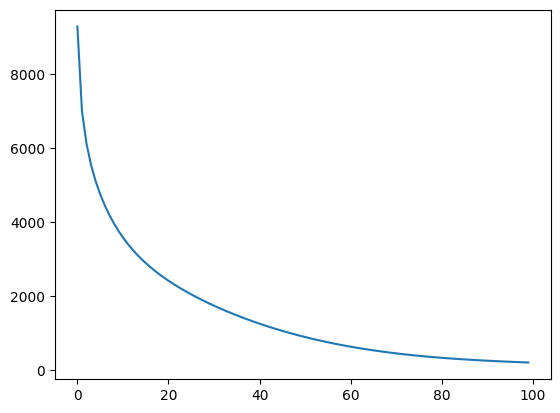

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

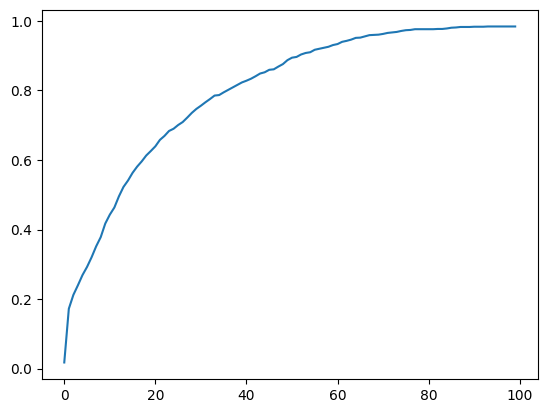

In [19]:
# Display accuracy over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [20]:
word1 = words_to_tensor(["boys"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["brothers"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["dignity"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

tensor([-0.4888, -0.8298,  0.8822, -1.8823, -0.3269,  1.1145,  1.9716, -0.2802,
        -0.3262,  0.1632, -3.3968, -0.0730, -0.1334, -2.2415, -1.5555, -0.3570,
         1.6437, -0.3748,  0.4256,  1.7422], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([-0.9643, -1.1034, -0.4844, -0.1139,  1.3608, -0.2714,  0.8800,  0.4128,
         0.1133,  0.1951, -0.2236, -1.2389, -0.1377, -0.1873, -0.2374,  0.1437,
        -1.1244, -0.8000,  0.0751,  0.1979], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([-0.3804, -0.6248,  2.1325, -3.0393,  0.1886,  0.5351, -0.5185,  0.1011,
         0.4702,  0.1068, -0.2972, -0.6455,  1.6522,  0.7556,  2.2222, -0.0858,
        -0.3587,  2.0041, -1.5055,  2.3427], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
2.4755921363830566
5.470966815948486
